In [2]:
import pandas as pd
import numpy as np

data=pd.read_csv(r'C:\Users\vmffl\workspace\우리은행 데이터경진대회 데이터셋\우리은행 데이터경진대회 데이터셋.csv',index_col=0)

for col_name in data.columns:
    data[col_name]=pd.Categorical(data[col_name])

from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(data,test_size=0.2, random_state=100)

X_trn=train_data.iloc[:,1:]
y_trn=train_data['TARGET']
X_tes=test_data.iloc[:,1:]
y_tes=test_data['TARGET']

from imblearn.over_sampling import SMOTEN
smoten = SMOTEN(random_state=1000)
X_trn_over, y_trn_over = smoten.fit_resample(X_trn,y_trn)

from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve

def get_eval(y_test,pred=None):
    confusion=confusion_matrix(y_test,pred)
    accuracy=accuracy_score(y_test,pred)
    precision=precision_score(y_test,pred)
    recall=recall_score(y_test, pred)
    f1 = f1_score(y_test,pred)
    precision2=precision_score(y_test,pred,pos_label=0)
    recall2=recall_score(y_test,pred,pos_label=0)
    f1_2=f1_score(y_test,pred,pos_label=0)
    print("confusion matrix")
    print(confusion)
    print('accuracy : {0:.4f} , precision : {1:.4f} , recall : {2:.4f}, F1 score : {3:.4f} \n precision(0) : {4:.4f} , recall(0) : {5:.4f}, f1(0) : {6:.4f}'.format(accuracy,precision, recall,f1,precision2,recall2,f1_2))

### KNN

In [3]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf=KNeighborsClassifier(n_neighbors=3)
knn_clf.fit(X_trn_over,y_trn_over)
pred=knn_clf.predict(X_tes)
get_eval(y_tes,pred)

confusion matrix
[[23705    46]
 [   73    83]]
accuracy : 0.9950 , precision : 0.6434 , recall : 0.5321, F1 score : 0.5825 
 precision(0) : 0.9969 , recall(0) : 0.9981, f1(0) : 0.9975


### VotingClassifier

In [4]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import CategoricalNB

lr_clf=LogisticRegression(max_iter=1000)
nb_clf=CategoricalNB(fit_prior=False)
rdf_clf=RandomForestClassifier(random_state=1000)
knn_clf=KNeighborsClassifier(n_neighbors=3)

In [7]:
vo_clf=VotingClassifier(estimators=[('LR',lr_clf),('NB',nb_clf)],voting='soft')
vo_clf.fit(X_trn_over,y_trn_over)
vo_pred=vo_clf.predict(X_tes)
get_eval(y_tes,vo_pred)

confusion matrix
[[19798  3953]
 [   50   106]]
accuracy : 0.8326 , precision : 0.0261 , recall : 0.6795, F1 score : 0.0503 
 precision(0) : 0.9975 , recall(0) : 0.8336, f1(0) : 0.9082


In [8]:
vo_clf2=VotingClassifier(estimators=[('RF',rdf_clf),('KNN',knn_clf)],voting='soft')
vo_clf2.fit(X_trn_over,y_trn_over)
vo_pred2=vo_clf2.predict(X_tes)
get_eval(y_tes,vo_pred2)

confusion matrix
[[23729    22]
 [   81    75]]
accuracy : 0.9957 , precision : 0.7732 , recall : 0.4808, F1 score : 0.5929 
 precision(0) : 0.9966 , recall(0) : 0.9991, f1(0) : 0.9978


### XGBoost

In [9]:
import xgboost as xgb
from xgboost import plot_importance

dtrain=xgb.DMatrix(data=X_trn.values, label=y_trn)
dtest=xgb.DMatrix(data=X_tes.values, label = y_tes)

In [19]:
params={'max_depth':6,'eta':0.1,'objective':'binary:logistic','eval_metric':'logloss','early_stopping':100}
wlist=[(dtrain,'train'),(dtest,'eval')]
xgb_model=xgb.train(params=params,dtrain=dtrain,num_boost_round=600,early_stopping_rounds=100,evals=wlist)

[19:19:12] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-logloss:0.60061	eval-logloss:0.60051
[1]	train-logloss:0.52456	eval-logloss:0.52470
[2]	train-logloss:0.46130	eval-logloss:0.46144
[3]	train-logloss:0.40788	eval-logloss:0.40807
[4]	train-logloss:0.36224	eval-logloss:0.36251
[5]	train-logloss:0.32310	eval-logloss:0.32329
[6]	train-logloss:0.28904	eval-logloss:0.28935
[7]	train-logloss:0.25948	eval-logloss:0.25976
[8]	train-logloss:0.23360	eval-logloss:0.23389
[9]	train-logloss:0.21088	eval-logloss:0.21113
[10]	train-logloss:0.19079	eval-logloss:0.19112
[11]	train-logloss:0.17310	eval-logloss:0.17339
[12]	train-logloss:0.15740	eval-logloss:0.15766
[13]	train-logloss:0.14347	eval-logloss:0.14377
[14]

[163]	train-logloss:0.01029	eval-logloss:0.01633
[164]	train-logloss:0.01026	eval-logloss:0.01629
[165]	train-logloss:0.01022	eval-logloss:0.01626
[166]	train-logloss:0.01017	eval-logloss:0.01622
[167]	train-logloss:0.01007	eval-logloss:0.01613
[168]	train-logloss:0.01001	eval-logloss:0.01608
[169]	train-logloss:0.00995	eval-logloss:0.01604
[170]	train-logloss:0.00989	eval-logloss:0.01599
[171]	train-logloss:0.00985	eval-logloss:0.01596
[172]	train-logloss:0.00976	eval-logloss:0.01590
[173]	train-logloss:0.00972	eval-logloss:0.01588
[174]	train-logloss:0.00965	eval-logloss:0.01582
[175]	train-logloss:0.00958	eval-logloss:0.01576
[176]	train-logloss:0.00954	eval-logloss:0.01575
[177]	train-logloss:0.00949	eval-logloss:0.01573
[178]	train-logloss:0.00945	eval-logloss:0.01572
[179]	train-logloss:0.00940	eval-logloss:0.01569
[180]	train-logloss:0.00933	eval-logloss:0.01565
[181]	train-logloss:0.00924	eval-logloss:0.01558
[182]	train-logloss:0.00920	eval-logloss:0.01555
[183]	train-logloss:

[331]	train-logloss:0.00398	eval-logloss:0.01170
[332]	train-logloss:0.00397	eval-logloss:0.01169
[333]	train-logloss:0.00396	eval-logloss:0.01169
[334]	train-logloss:0.00394	eval-logloss:0.01166
[335]	train-logloss:0.00393	eval-logloss:0.01165
[336]	train-logloss:0.00392	eval-logloss:0.01164
[337]	train-logloss:0.00390	eval-logloss:0.01161
[338]	train-logloss:0.00389	eval-logloss:0.01159
[339]	train-logloss:0.00388	eval-logloss:0.01159
[340]	train-logloss:0.00386	eval-logloss:0.01158
[341]	train-logloss:0.00385	eval-logloss:0.01156
[342]	train-logloss:0.00384	eval-logloss:0.01155
[343]	train-logloss:0.00381	eval-logloss:0.01153
[344]	train-logloss:0.00380	eval-logloss:0.01153
[345]	train-logloss:0.00379	eval-logloss:0.01153
[346]	train-logloss:0.00377	eval-logloss:0.01151
[347]	train-logloss:0.00375	eval-logloss:0.01151
[348]	train-logloss:0.00373	eval-logloss:0.01150
[349]	train-logloss:0.00371	eval-logloss:0.01148
[350]	train-logloss:0.00370	eval-logloss:0.01148
[351]	train-logloss:

[499]	train-logloss:0.00228	eval-logloss:0.01064
[500]	train-logloss:0.00227	eval-logloss:0.01063
[501]	train-logloss:0.00226	eval-logloss:0.01063
[502]	train-logloss:0.00226	eval-logloss:0.01063
[503]	train-logloss:0.00225	eval-logloss:0.01062
[504]	train-logloss:0.00224	eval-logloss:0.01062
[505]	train-logloss:0.00224	eval-logloss:0.01062
[506]	train-logloss:0.00223	eval-logloss:0.01061
[507]	train-logloss:0.00222	eval-logloss:0.01060
[508]	train-logloss:0.00222	eval-logloss:0.01060
[509]	train-logloss:0.00221	eval-logloss:0.01060
[510]	train-logloss:0.00221	eval-logloss:0.01060
[511]	train-logloss:0.00220	eval-logloss:0.01060
[512]	train-logloss:0.00219	eval-logloss:0.01060
[513]	train-logloss:0.00219	eval-logloss:0.01060
[514]	train-logloss:0.00218	eval-logloss:0.01061
[515]	train-logloss:0.00217	eval-logloss:0.01061
[516]	train-logloss:0.00217	eval-logloss:0.01060
[517]	train-logloss:0.00216	eval-logloss:0.01061
[518]	train-logloss:0.00215	eval-logloss:0.01060
[519]	train-logloss:

In [20]:
pred_probs=xgb_model.predict(dtest)
pred=[1 if x>0.5 else 0 for x in pred_probs]
get_eval(y_tes,pred)

confusion matrix
[[23739    12]
 [   62    94]]
accuracy : 0.9969 , precision : 0.8868 , recall : 0.6026, F1 score : 0.7176 
 precision(0) : 0.9974 , recall(0) : 0.9995, f1(0) : 0.9984


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

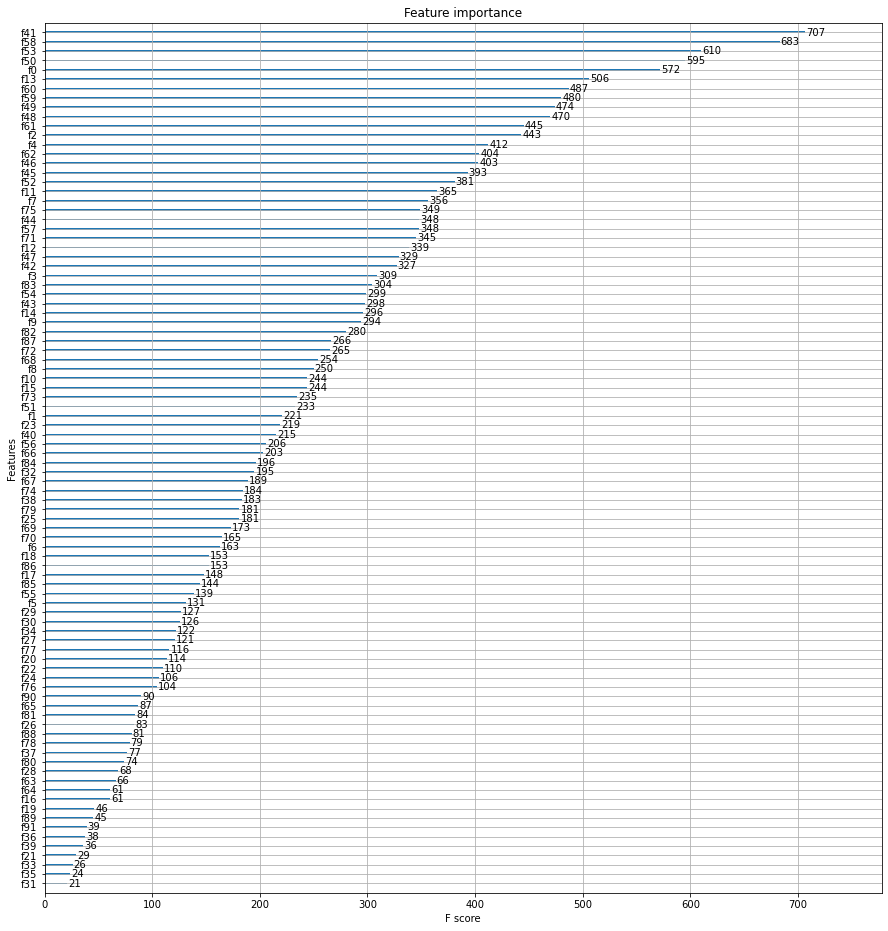

In [21]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15,16))
plot_importance(xgb_model, ax=ax)